In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ankurzing_sentiment_analysis_for_financial_news_path = kagglehub.dataset_download('ankurzing/sentiment-analysis-for-financial-news')

print('Data source import complete.')


100%|██████████| 903k/903k [00:00<00:00, 47.7MB/s]

Extracting files...
Data source import complete.



    
    
In this short notebook I will show how you can use FinBERT easily for sentiment analysis.
FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

The model will give softmax outputs for three labels: positive, negative or neutral.

# 1 SETUP

In [2]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

I now read the input file. I will add the column headers, since they are not present in the csv file.

In [4]:
import kagglehub
import pandas as pd

# Download dataset and get local path
dataset_path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")
print("Dataset downloaded to:", dataset_path)

# Now read the CSV from the correct local path
data = pd.read_csv(f"{dataset_path}/all-data.csv",
                   encoding="unicode_escape",
                   names=["Sentiment", "Text"])
print(data.head())

Using Colab cache for faster access to the 'sentiment-analysis-for-financial-news' dataset.
Dataset downloaded to: /kaggle/input/sentiment-analysis-for-financial-news
  Sentiment                                               Text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [5]:
data.shape

(4846, 2)

In total we have 4846 observations for those we can predict the sentiment.

# 2 PREPARATION
The first thing we do, is to separate the columns. The `Text` column will be our `X` which we will feed into FinBERT and `Sentiment` is our target in which we are interested, I will safe it into `y`.
There is no need to specify a train or testset, we will use the pretrained model directly to predict the sentiment.

In [6]:
X = data['Text'].to_list()
y = data['Sentiment'].to_list()

In the next step I will directly download [FinBERT](https://huggingface.co/ProsusAI/finbert) directly from Huggingface.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

# 3 PREDICT
Finally we are able to loop over the X list and predict for every entry the label. I will safe the predicted label as well as the probability for that class.

In [8]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

# 4 EVALUATION
Let´s check the performance of our model quick.

In [9]:
print(f'Accuracy-Score: {accuracy_score(y, preds)}')

Accuracy-Score: 0.8893933140734627


In [10]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

    negative       0.80      0.97      0.88       604
     neutral       0.96      0.86      0.91      2879
    positive       0.81      0.92      0.86      1363

    accuracy                           0.89      4846
   macro avg       0.86      0.92      0.88      4846
weighted avg       0.90      0.89      0.89      4846



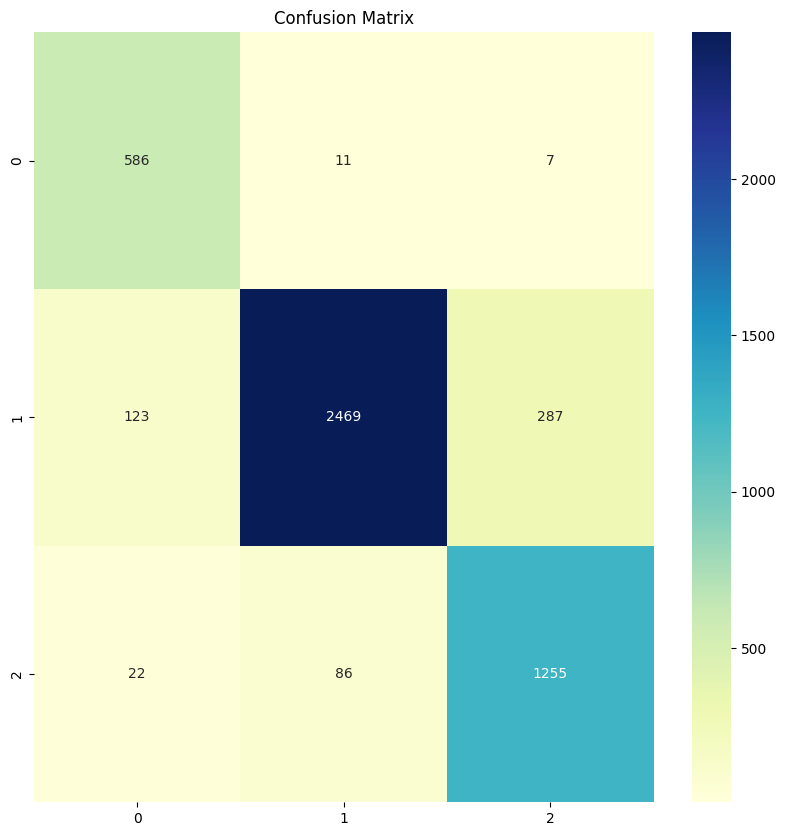

In [11]:
cm = confusion_matrix(y, preds)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show();

The output is really good. Around 89% accuracy without any fine-tuning.

Base LIne Comparison


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data["Text"], data["Sentiment"],
                                                    test_size=0.2, random_state=42,
                                                    stratify=data["Sentiment"])

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression
clf = LogisticRegression(max_iter=200, class_weight="balanced")
clf.fit(X_train_tfidf, y_train)
baseline_preds = clf.predict(X_test_tfidf)

print("=== Baseline Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, baseline_preds))
print(classification_report(y_test, baseline_preds))


=== Baseline Logistic Regression ===
Accuracy: 0.734020618556701
              precision    recall  f1-score   support

    negative       0.58      0.69      0.63       121
     neutral       0.83      0.78      0.81       576
    positive       0.63      0.65      0.64       273

    accuracy                           0.73       970
   macro avg       0.68      0.71      0.69       970
weighted avg       0.74      0.73      0.74       970



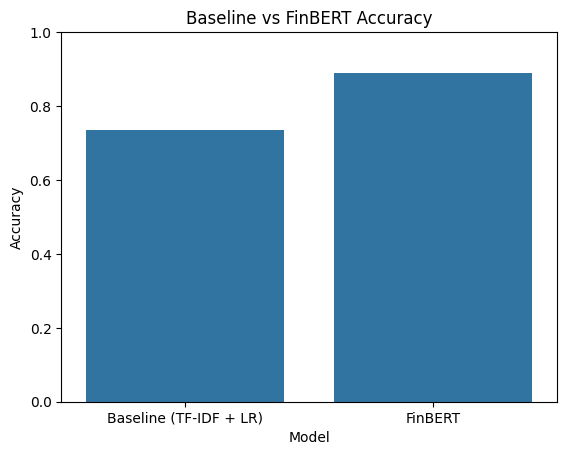

In [13]:
results = pd.DataFrame({
    "Model": ["Baseline (TF-IDF + LR)", "FinBERT"],
    "Accuracy": [
        accuracy_score(y_test, baseline_preds),
        accuracy_score(y, preds)  # careful: preds used full dataset
    ]
})

sns.barplot(x="Model", y="Accuracy", data=results)
plt.title("Baseline vs FinBERT Accuracy")
plt.ylim(0,1)
plt.show()


In [14]:
sample_df = data.sample(5, random_state=42)
for text in sample_df["Text"]:
    print(f"Text: {text}")
    print(f"True: {sample_df[sample_df['Text']==text]['Sentiment'].values[0]}")
    pred = finbert_label = preds[X.index(text)]
    print(f"Predicted: {pred}\n")


Text: The company was supposed to deliver machinery to a veneer mill in the Tomsk region , in Russia .
True: neutral
Predicted: neutral

Text: UNC Charlotte would also deploy SSH Tectia Connector to enable secure application connectivity .
True: neutral
Predicted: neutral

Text: In 2009 , Lee & Man had a combined annual production capacity of close to 4.5 million tonnes of paper and 300,000 tonnes of pulp .
True: neutral
Predicted: neutral

Text: `` That 's a very high figure on the European scale , '' Noop said , recalling however that this also includes beer bought by Finnish tourists .
True: neutral
Predicted: neutral

Text: In Finland , the corresponding service is Alma Media 's Etuovi.com , Finland 's most popular and best known nationwide online service for home and property sales .
True: neutral
Predicted: neutral

